In [3]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_ENABLE_ONEDNN_OPTS'] =  "0"



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

## Librerías
import seaborn as sns
import sys
import cv2 as cv2
import glob
from PIL import Image
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import gc
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import os


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

print(tf.__version__)

2024-09-19 00:03:26.813084: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 00:03:26.813116: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 00:03:26.817856: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-19 00:03:27.259435: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.14.0


In [4]:
## Uso de GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2024-09-19 00:03:31.969913: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-19 00:03:32.043895: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-19 00:03:32.044114: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Dataset

In [5]:
## function to load images
def load_binary_images(file_names):  
    image = np.load(file_names).astype(np.float32)
    image = np.expand_dims(image, axis=-1)
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.image.resize(image, [32,32])   
    ## binariazar
    image = tf.where(image > 0.5, 1.0, 0.0)  
    return image

def load_images(file_names):
    image = np.load(file_names).astype(np.float32)
    #expand_dims
    image = np.expand_dims(image, axis=-1)
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.image.resize(image, [32,32])/255.0    
      
    return image

def min_max_scaler(ruta,image):
    ## load images in the path
    images = glob.glob(ruta + '/*.npy')
    images = sorted(images)
    ## load images
    images = [load_images(image) for image in images]
    ## min max scaler of thei image using the max and min of all images
    images = np.array(images)
    max_value = np.max(images)
    min_value = np.min(images)
    image = tf.math.abs((image - min_value)/(max_value - min_value))
    return image   

## Function to get contours and features
def get_contours_and_features(binary_map):
    #https://docs.opencv.org/4.x/d3/d05/tutorial_py_table_of_contents_contours.html
    #binary_map = cv2.cvtColor(binary_map, cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_features = []
    for contour in contours:
        error = 1e-5
        moments = cv2.moments(contour)
        cx = moments['m10'] / (moments['m00'] + error)
        cy = moments['m01'] / (moments['m00'] + error)
        center_of_mass = [cx, cy]
        x,y,w,h = cv2.boundingRect(contour)        
        rect_area = w*h
        features = {
            'bounding_box': (x,y,w,h),
            'area': cv2.contourArea(contour),
            'perimeter': cv2.arcLength(contour, True),       
            #'solidity': np.float32(cv2.contourArea(contour))/cv2.convexHull(contour),
            'equivalent_diameter': np.sqrt(4*cv2.contourArea(contour)/np.pi),            
            'moments': moments,
            'center_of_mass': center_of_mass,
            'contour': contour
        }
        contours_features.append(features)
        del features
    #plt.imshow(contours_map, cmap='gray')
    return contours_features

# function to get a determined property from a list of contours features (area by default)
def get_item(contour_features, key='area'):
    areas = []
    for contour_feature in contour_features:
        area =  contour_feature[key]
        areas.append(area)
    return areas

## function to get geometric_attributes
def get_geometric_atributes(binary_images):
    descriptors = []
    for binary_img in binary_images:
        ## Formato
        image = binary_img.numpy().astype(np.uint8)       
        
        ## Capturar contornos
        contour_features = get_contours_and_features(image)
        
        ## Calcular vector de áreas de poro (todos los poros)
        areas = get_item(contour_features, key='area')

        ## Calcular vector de perímetros de poro (todo los poros)
        pmtro = get_item(contour_features, key='perimeter')

        ## Calcular el diametro equivalente de los poros
        eq_diameter = get_item(contour_features, key='equivalent_diameter')                

        descriptor = [np.mean(areas), np.mean(pmtro),np.mean(eq_diameter)]
        
        descriptors.append(descriptor)
        
    
    return descriptors

## function to get the middle image route in the folder
def get_middle_image(folder_route):
    ## get list of images
    images = glob.glob(folder_route + '/*.npy')
    ## order images
    images = sorted(images)
    ## get index of middle image
    if len(images) == 0:
        indx = -1
        middle_image = 'empty'
    else:
        indx = len(images)//2
        middle_image = images[indx]   
    
    return middle_image

In [6]:
## annotations to get nodule_features
annotations_cvs_4R = pd.read_csv('/data/Datasets/Nodules_ISBI/meta_created_info_3d_3R.csv')
annotations_csv_3R = pd.read_csv('/data/Datasets/Nodules_ISBI/meta_created_info_3d_4R.csv')
annotations = pd.concat([annotations_cvs_4R, annotations_csv_3R], ignore_index=True)
## drop malignancy = 3
annotations = annotations[annotations['malignancy'] != 3]
annotations

,patient_id,nodule_no,folder,malignancy,is_cancer,calcification,lobulation,texture,spiculation,subtlety,margin,intercept,slope
0,34,0,LICD-0034_NI000,2,False,6,1,5,1,5,5,-1024.0,1.0
1,45,2,LICD-0045_NI002,4,True,6,4,5,4,4,4,-1024.0,1.0
2,58,0,LICD-0058_NI000,5,True,6,3,5,5,5,4,-1024.0,1.0
3,72,0,LICD-0072_NI000,5,True,6,3,4,4,5,3,-1024.0,1.0
4,75,1,LICD-0075_NI001,5,True,6,3,5,5,5,4,-1024.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,1007,0,LICD-1007_NI000,2,False,6,1,5,1,3,4,-1024.0,1.0
917,1011,0,LICD-1011_NI000,4,True,6,1,4,4,5,4,-1024.0,1.0
918,1011,1,LICD-1011_NI001,5,True,6,3,5,2,5,4,-1024.0,1.0
919,1011,2,LICD-1011_NI002,5,True,6,3,5,3,5,3,-1024.0,1.0


In [7]:
## ruta dataset
rutas_images_npy = glob.glob('/data/Datasets/Nodules_ISBI/images/*/*.npy')

## order list by folder
rutas_images_npy = sorted(rutas_images_npy)

## get list of folders
folders = [ruta.split('/')[-2] for ruta in rutas_images_npy]
folders = np.unique(folders)

## build dataframe
rutas_images = []
rutas_masks = []
areas = []
perimetros = []
diametros = []
calsifications = []
spiculations = []
lobulations = []
sphericities = []
textures = []
margins = []
subletys = []

## cancer or not
labels = []
    
for folder in folders:
    ruta = '/data/Datasets/Nodules_ISBI/images/' + folder
    ruta_masc = '/data/Datasets/Nodules_ISBI/masks/' + folder
    
    ## load middle image route
    image_route = get_middle_image(ruta)
    name_image = image_route.split('/')[-1]
    mask_route = ruta_masc + '/' + name_image       
    
    if image_route != 'empty':    
        ## get attributes
        image = load_images(image_route)
        ## min-max scaler
        image = min_max_scaler(ruta, image)
        ## binary image
        binary_image = load_binary_images(mask_route)   
        ## get features of the image            
        features = annotations[annotations['folder'] == folder]
        if features.shape[0] != 0:     
            ## append rutas
            geometric_attributes = get_geometric_atributes([binary_image])[0]
            rutas_images.append(image_route)
            rutas_masks.append(mask_route)
            
            ## append attributes
            areas.append(geometric_attributes[0])
            perimetros.append(geometric_attributes[1])
            diametros.append(geometric_attributes[2])    
            
            ## evaluar si son nan e iomprimir solo si los  
              
            malignancy = features['malignancy'].values[0]
            calsification = features['calcification'].values[0]
            spiculation = features['spiculation'].values[0]
            lobulation = features['lobulation'].values[0]
            texture = features['texture'].values[0]
            label = features['is_cancer'].values[0]
            margin = features['margin'].values[0]
            sublety = features['subtlety'].values[0]
            
            ## append featuresprint(features)
            calsifications.append(calsification)
            spiculations.append(spiculation)
            lobulations.append(lobulation)
            textures.append(texture)
            labels.append(label)
            margins.append(margin)
            subletys.append(sublety)


## build dataframe
df = pd.DataFrame()
df['ruta'] = rutas_images
df['mask'] = rutas_masks
df['area'] = areas
df['perimetro'] = perimetros
df['diametro'] = diametros
df['calsification'] = calsifications
df['spiculation'] = spiculations
df['lobulation'] = lobulations
df['texture'] = textures
df['margin'] = margins
df['sublety'] = subletys
df['label'] = labels

### eliminar filas con valores nan y decir cuantas se borraron
#print('Filas antes de eliminar nan:', df.shape[0])
#df = df.dropna()
#print('Filas después de eliminar nan:', df.shape[0])

df

2024-09-19 00:04:16.784299: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-19 00:04:16.785918: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-19 00:04:16.786185: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

,ruta,mask,area,perimetro,diametro,calsification,spiculation,lobulation,texture,margin,sublety,label
0,/data/Datasets/Nodules_ISBI/images/LICD-0001_N...,/data/Datasets/Nodules_ISBI/masks/LICD-0001_NI...,128.5,49.213203,12.791063,6,5,3,5,4,5,True
1,/data/Datasets/Nodules_ISBI/images/LICD-0003_N...,/data/Datasets/Nodules_ISBI/masks/LICD-0003_NI...,86.0,36.970562,10.464158,6,3,2,4,3,5,True
2,/data/Datasets/Nodules_ISBI/images/LICD-0003_N...,/data/Datasets/Nodules_ISBI/masks/LICD-0003_NI...,39.5,24.727922,7.091753,6,2,2,5,4,4,True
3,/data/Datasets/Nodules_ISBI/images/LICD-0003_N...,/data/Datasets/Nodules_ISBI/masks/LICD-0003_NI...,50.0,26.970562,7.978846,6,1,1,5,5,4,True
4,/data/Datasets/Nodules_ISBI/images/LICD-0004_N...,/data/Datasets/Nodules_ISBI/masks/LICD-0004_NI...,10.5,14.242641,3.656366,3,1,1,5,5,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...
528,/data/Datasets/Nodules_ISBI/images/LICD-1007_N...,/data/Datasets/Nodules_ISBI/masks/LICD-1007_NI...,16.0,16.485281,4.513517,6,1,1,5,4,3,False
529,/data/Datasets/Nodules_ISBI/images/LICD-1011_N...,/data/Datasets/Nodules_ISBI/masks/LICD-1011_NI...,117.5,43.556349,12.231339,6,4,1,4,4,5,True
530,/data/Datasets/Nodules_ISBI/images/LICD-1011_N...,/data/Datasets/Nodules_ISBI/masks/LICD-1011_NI...,70.5,36.384776,9.474354,6,2,3,5,4,5,True
531,/data/Datasets/Nodules_ISBI/images/LICD-1011_N...,/data/Datasets/Nodules_ISBI/masks/LICD-1011_NI...,81.5,35.213203,10.186708,6,3,3,5,3,5,True


## Dataset

In [9]:
## shuffle data
df_train_1, df_test = train_test_split(df, test_size=0.2, random_state=42)

## validation split
val_pctg = 0.8
split_validation_index = int(df_train_1.shape[0]*val_pctg)
df_train = df_train_1.iloc[:split_validation_index]
df_validation = df_train_1.iloc[split_validation_index:]

print('---- Distribución de entrenamiento, validación y test para benignos y malignos ----')
print('Malignos: ')
print('Positive train shape: ', df_train[df_train['label'] == 'True'].shape[0])
print('Positive val shape: ', df_validation[df_validation['label'] == 'True'].shape[0])
print('Positive test shape: ', df_test[df_test['label'] == 'True'].shape[0])

print('Benignos: ')
print('Negative train shape: ', df_train[df_train['label'] == 'False'].shape[0])
print('Negative val shape: ', df_validation[df_validation['label'] == 'False'].shape[0])
print('Negative test shape: ', df_test[df_test['label'] == 'False'].shape[0])


## replace labels
df_train.loc[:, 'label'] = df_train['label'].replace({'True': 1, 'False': 0})
df_test.loc[:, 'label'] = df_test['label'].replace({'True': 1, 'False': 0})
df_validation.loc[:, 'label'] = df_validation['label'].replace({'True': 1, 'False': 0})

print('---- Dataset finales ----')
print('Train shape: ', df_train.shape[0])
print('Test shape: ', df_test.shape[0])
print('Validation shape: ', df_validation.shape[0])

---- Distribución de entrenamiento, validación y test para benignos y malignos ----
Malignos: 
Positive train shape:  227
Positive val shape:  59
Positive test shape:  73
Benignos: 
Negative train shape:  113
Negative val shape:  27
Negative test shape:  34
---- Dataset finales ----
Train shape:  340
Test shape:  107
Validation shape:  86


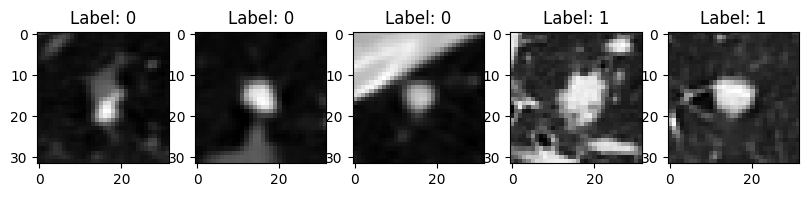

In [10]:
## plot 5 first images with mas on the df train dataset
plt.figure(figsize=(20,10))
for i in range(5):
    image = load_images(df_train['ruta'].values[i])    
    plt.subplot(1,10,i+1)
    plt.imshow(image, cmap='gray')   
    plt.title('Label: ' + str(df_train['label'].values[i]))

In [11]:
## create dataset function 
features_to_use = ['area','lobulation', 'texture', 'spiculation', 'margin', 'calsification', 'sublety']


def create_train_dataset(batch,df):
    images_routes = df['ruta'].to_numpy()
    mask_routes = df['mask'].to_numpy()
    labels = df['label'].to_numpy()
    features = df[features_to_use].to_numpy()
    
    
    ## Data augmentation    
    def rotate90_image(image):
        ## rotate 90 degrees
        image = tf.image.rot90(image)
        return image
    
    def rotate180_image(arg):
        ## rotate 180 degrees
        image = tf.image.rot90(arg, k=2)
        return image
    
    def rotate270_image(arg):
        ## rotate 270 degrees
        image = tf.image.rot90(arg, k=3)
        return image
    
    images = []
    mask = []
    new_labels = []
    new_features = []
    for image_route, mask_route, label, features in zip(images_routes,mask_routes, labels,features):
        ## imagenes y mascaras originales
        image_original = load_images(image_route)
        mask_original = load_binary_images(mask_route)
        
        ## augmentaciones
        # imagen original
        #image_left_flip = flip_left_image(image_original)
        image_rotate90 = rotate90_image(image_original)
        image_rotate180 = rotate180_image(image_original)
        image_rotate270 = rotate270_image(image_original)
        #image_up_flip = flip_up_image(image_original)
        ## mascara original
        #mask_left_flip = flip_left_image(mask_original)
        mask_rotate90 = rotate90_image(mask_original)
        mask_rotate180 = rotate180_image(mask_original)
        mask_rotate270 = rotate270_image(mask_original)
        #mask_up_flip = flip_up_image(mask_original)
        
        ## append image augmentation
        images.append(image_original)        
        images.append(image_rotate90)
        images.append(image_rotate180)
        images.append(image_rotate270)
        
        
        ## append mask augmentation
        mask.append(mask_original)        
        mask.append(mask_rotate90)
        mask.append(mask_rotate180)
        mask.append(mask_rotate270)
        
        ## append labels        
        new_labels.append(label)
        new_labels.append(label)
        new_labels.append(label)
        new_labels.append(label)           
        
        ## append features  
        new_features.append(features)
        new_features.append(features)
        new_features.append(features)
        new_features.append(features)
        
        
        
        
    ## convert to tensor
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    masks = tf.convert_to_tensor(mask, dtype=tf.float32)
    labels = tf.convert_to_tensor(new_labels, dtype=tf.float32)
    features = tf.convert_to_tensor(new_features, dtype=tf.float32)    
    
    
    dataset = tf.data.Dataset.from_tensor_slices((images, masks, features, labels))
    
    ## shuffle data
    dataset = dataset.shuffle(buffer_size=1000,seed=42)
    
    ## apply preprocess_image function
    dataset = dataset.map(lambda image, mask, features, label: (image, mask, features, label))
    
    dataset = dataset.batch(batch)
    
    return dataset


## create dataset function 
def create_test_dataset(batch,df):       
    images_routes = df['ruta'].to_numpy()
    mask_routes = df['mask'].to_numpy()
    labels = df['label'].to_numpy()
    features = df[features_to_use].to_numpy()
    
    
    images = []
    for image_route in images_routes:
        image = load_images(image_route)
        images.append(image)
        
    masks = []
    for mask_route in mask_routes:
        mask = load_binary_images(mask_route)
        masks.append(mask)
        
    ## convert to tensor
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    masks = tf.convert_to_tensor(mask, dtype=tf.float32)
    labels = tf.convert_to_tensor(labels, dtype=tf.float32)
    features = tf.convert_to_tensor(features, dtype=tf.float32)    
    
    dataset = tf.data.Dataset.from_tensor_slices((images, masks, features, labels))
    
    ## apply preprocess_image function
    dataset = dataset.map(lambda image, masks, features, label: (image, masks, features, label))
      
    dataset.batch(batch)
    
    return dataset

## both-clases
train_dataset = create_train_dataset(8, df_train)


for image, mask, features, label in train_dataset:
    print(image.shape)
    print(mask.shape)
    print(features.shape)
    print(label.shape)    
    break

i = 0 
for image, mask, features, label in train_dataset:
    i += np.shape(image)[0]   

print('Total de imagenes en el dataset de entrenamiento:', i)

(8, 32, 32, 1)
(8, 32, 32, 1)
(8, 7)
(8,)
Total de imagenes en el dataset de entrenamiento: 1360


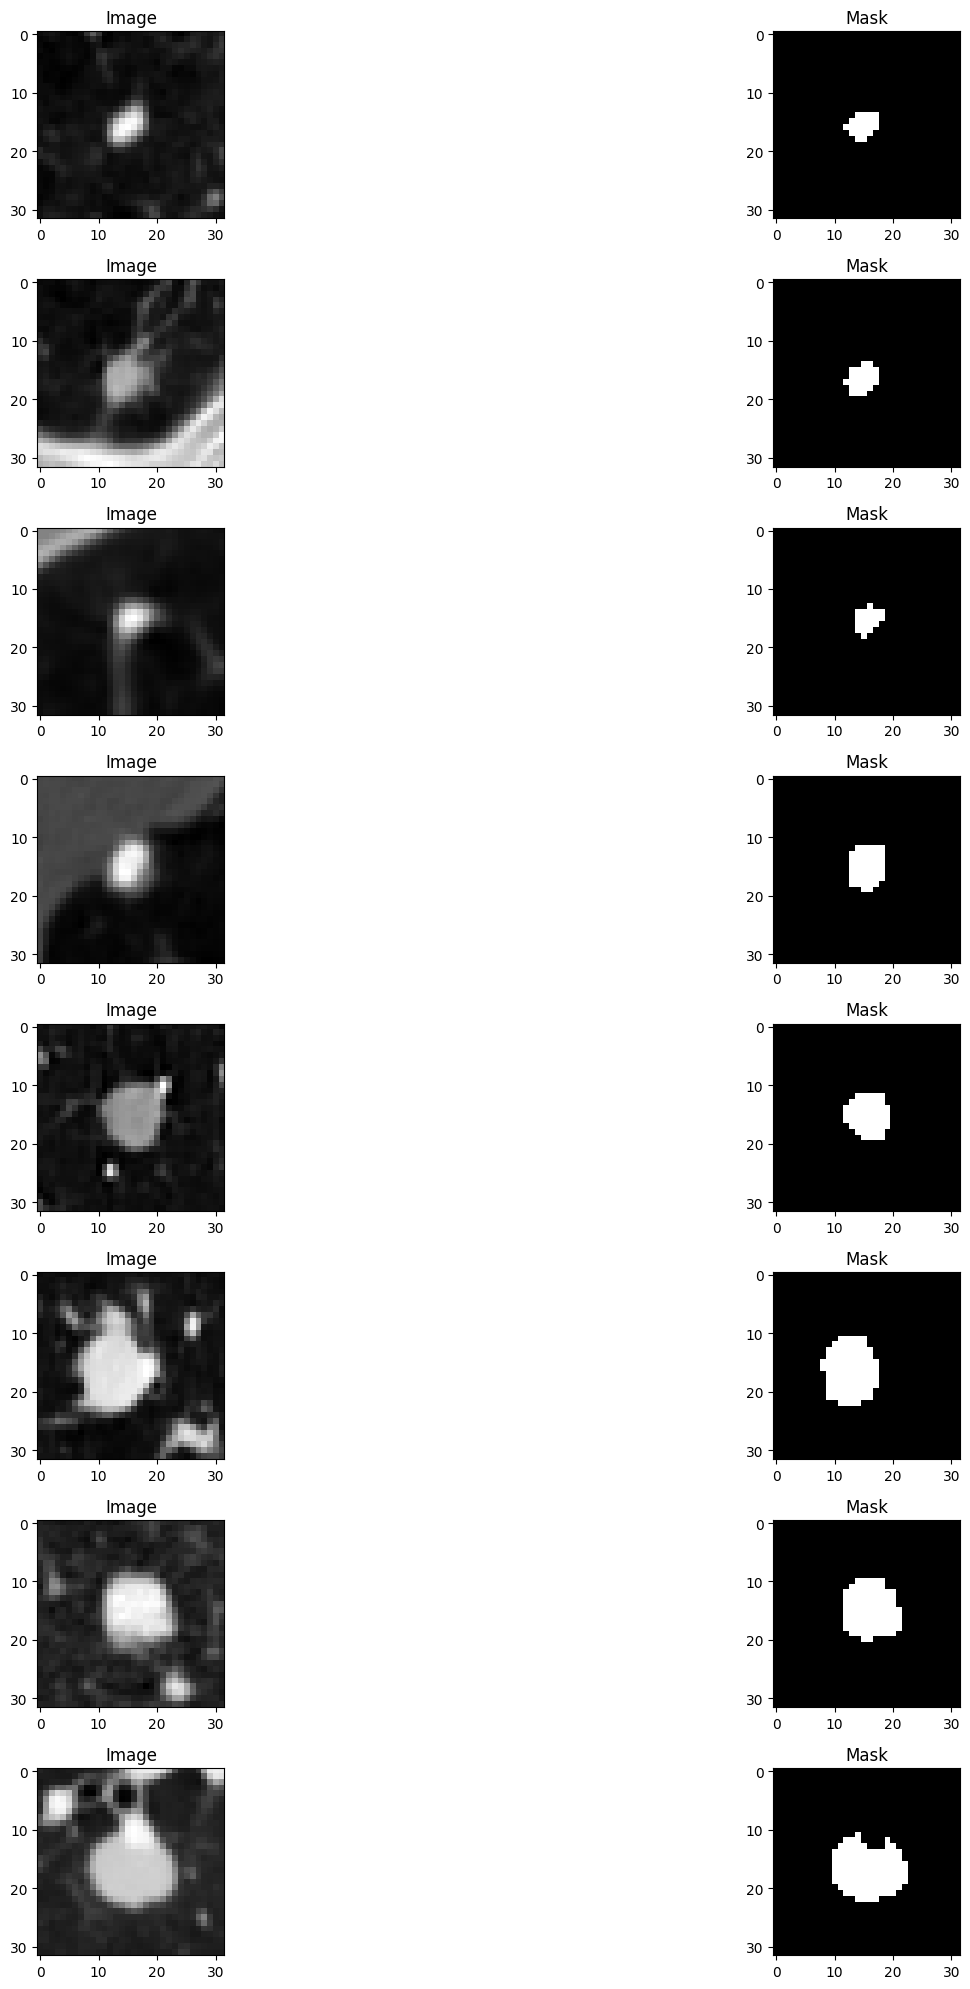

In [12]:
for image, mask, features, label in train_dataset:
    ## plot 8 batch images and their mask
    plt.figure(figsize=(20,20))
    for i in range(8):
        plt.subplot(8,2,2*i+1)
        plt.imshow(image[i], cmap='gray')       
        plt.title('Image')
        plt.subplot(8,2,2*i+2)
        plt.imshow(mask[i], cmap='gray')
        plt.title('Mask')
        
    plt.tight_layout()
    plt.show()
    break

# Variational autoencoders

In [13]:
# Hiperparámetros
epochs = 2000
learning_rate = 0.0001
batch = 32

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## GVAE

### Encoder

In [15]:
###_____________________________ENCODER________________________##
latent_dim = 16

nx, ny = 32, 32

encoder_inputs = keras.Input(shape=(nx, ny, 1))

## decoder
nfilters = 16
latent_dim = 16
nx , ny = 32, 32


encoder_input = keras.Input(shape=(nx,ny,1), name='original_img')

c1 = layers.Conv2D(nfilters*1, kernel_size=(3,3),
               kernel_initializer='he_normal', padding='same')(encoder_input)
c1 = layers.BatchNormalization()(c1)
c1 = layers.Activation('relu')(c1)
p1 = layers.MaxPooling2D((2,2))(c1)
p1 = layers.Dropout(0.1)(p1)

c2 = layers.Conv2D(nfilters*2, kernel_size=(3,3),
               kernel_initializer='he_normal', padding='same')(p1)
c2 = layers.BatchNormalization()(c2)
c2 = layers.Activation('relu')(c2)
p2 = layers.MaxPooling2D((2,2))(c2)

c3 = layers.Conv2D(nfilters*4, kernel_size=(3,3),
               kernel_initializer='he_normal', padding='same')(p2)
c3 = layers.BatchNormalization()(c3)
c3 = layers.Activation('relu')(c3)
p3 = layers.MaxPooling2D((2,2))(c3)
p3 = layers.Dropout(0.1)(p3)

c4 = layers.Conv2D(nfilters*8, kernel_size=(3,3),
               kernel_initializer='he_normal', padding='same')(p3)
c4 = layers.BatchNormalization()(c4)
c4 = layers.Activation('relu')(c4)
p4 = layers.MaxPooling2D((2,2))(c4)
p4 = layers.Dropout(0.1)(p4)

c5 = layers.Conv2D(nfilters*16, kernel_size=(3,3),
               kernel_initializer='he_normal', padding='same')(p4)

# Flatten and Embedding
c5_flatten = layers.Flatten()(c5)
x = layers.Dense(latent_dim, name='embedding')(c5_flatten)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(inputs=encoder_input , outputs=[z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 original_img (InputLayer)   [(None, 32, 32, 1)]          0         []                            


                                                                                                  
 conv2d_5 (Conv2D)           (None, 32, 32, 16)           160       ['original_img[0][0]']        
                                                                                                  
 batch_normalization_4 (Bat  (None, 32, 32, 16)           64        ['conv2d_5[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_4 (Activation)   (None, 32, 32, 16)           0         ['batch_normalization_4[0][0]'
                                                                    ]                             
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 16)           0         ['activation_4[0][0]']        
 g2D)     

### Decoder

In [16]:
## ------------------ decoder -------------------------
## Entrada Z
latent_inputs = keras.Input(shape=(latent_dim,))

## decoder layers from embedding
d1_dec = layers.Dense(2*2*256, activation='relu')(latent_inputs)
d1_dec = layers.Reshape((2, 2, 256))(d1_dec)

u1_dec = layers.Conv2DTranspose(nfilters*16, (2,2), strides=(2,2), padding='same')(d1_dec)
u1_dec = layers.Dropout(0.1)(u1_dec)
c6_dec = layers.Conv2D(nfilters*16, kernel_size=(3,3),
               kernel_initializer='he_normal', padding='same')(u1_dec)
c6_dec = layers.BatchNormalization()(u1_dec)
c6_dec = layers.Activation('relu')(u1_dec)

u2_dec = layers.Conv2DTranspose(nfilters*8, (2,2), strides=(2,2), padding='same')(c6_dec)
u2_dec = layers.Dropout(0.1)(u2_dec)
c7_dec = layers.Conv2D(nfilters*8, kernel_size=(3,3),
               kernel_initializer='he_normal', padding='same')(u2_dec)
c7_dec = layers.BatchNormalization()(u2_dec)
c7_dec = layers.Activation('relu')(u2_dec)

u3_dec = layers.Conv2DTranspose(nfilters*4, (2,2), strides=(2,2), padding='same')(c7_dec)
u3_dec = layers.Dropout(0.1)(u3_dec)
c8_dec = layers.Conv2D(nfilters*4, kernel_size=(3,3),
               kernel_initializer='he_normal', padding='same')(u3_dec)
c8_dec = layers.BatchNormalization()(u3_dec)
c8_dec = layers.Activation('relu')(u3_dec)

u4_dec = layers.Conv2DTranspose(nfilters*2, (2,2), strides=(2,2), padding='same')(c8_dec)
u4_dec = layers.Dropout(0.1)(u4_dec)
c9_dec = layers.Conv2D(nfilters*2, kernel_size=(3,3),
               kernel_initializer='he_normal', padding='same')(u4_dec)
c9_dec = layers.BatchNormalization()(u4_dec)
c9_dec = layers.Activation('relu')(u4_dec)

segmentation_output = layers.Conv2D(1, (1,1), activation='sigmoid', name='segmentation')(c9_dec)

## decoder model
decoder = keras.Model(latent_inputs, segmentation_output, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense (Dense)               (None, 1024)              17408     
                                                                 
 reshape (Reshape)           (None, 2, 2, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 256)         262400    
 anspose)                                                        
                                                                 
 dropout_6 (Dropout)         (None, 4, 4, 256)         0         
                                                                 
 activation_8 (Activation)   (None, 4, 4, 256)         0         
                                                           

# Model

In [17]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            image = data[0]
            mask = data[1]
            z_mean, z_log_var, z = self.encoder(image)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.math.abs(tf.reduce_mean(
                tf.reduce_sum(
                   keras.losses.binary_crossentropy(mask, reconstruction), axis=(1, 2)
                )
            ))            
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))            
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))                      
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [18]:
vae = VAE(encoder, decoder)
opt = tf.optimizers.Adam(learning_rate = learning_rate )
#nll = lambda x , rv_x: -rv_x.log_prob(x)
vae.compile(optimizer=opt)


vae.fit(train_dataset, epochs=epochs, 
                batch_size=batch,
                         callbacks=[tf.keras.callbacks.EarlyStopping(monitor='kl_loss', patience=30)])

Epoch 1/2000


2024-09-19 00:10:34.646806: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-09-19 00:10:37.969507: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1dc710cc30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-19 00:10:37.969699: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-09-19 00:10:38.061896: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-19 00:10:38.331591: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


170/170 [==============================] - 10s 7ms/step - loss: 151943.8483 - reconstruction_loss: 283.7472 - kl_loss: 66916.8438
Epoch 2/2000
170/170 [==============================] - 1s 8ms/step - loss: 1236.3632 - reconstruction_loss: 101.3852 - kl_loss: 914.4185
Epoch 3/2000
170/170 [==============================] - 1s 7ms/step - loss: 320.9768 - reconstruction_loss: 108.2259 - kl_loss: 140.1458
Epoch 4/2000
170/170 [==============================] - 1s 9ms/step - loss: 160.8277 - reconstruction_loss: 97.5706 - kl_loss: 58.1731
Epoch 5/2000
170/170 [==============================] - 1s 9ms/step - loss: 138.2342 - reconstruction_loss: 88.9889 - kl_loss: 46.0635
Epoch 6/2000
170/170 [==============================] - 1s 9ms/step - loss: 123.6435 - reconstruction_loss: 81.2510 - kl_loss: 40.3381
Epoch 7/2000
170/170 [==============================] - 1s 7ms/step - loss: 111.5978 - reconstruction_loss: 78.3599 - kl_loss: 35.9362
Epoch 8/2000
170/170 [==============================] -

In [19]:
### Guardar modelohttps://www.tensorflow.org/guide/saved_model?hl=es-419
vae.encoder.save('VAE_Models/GVAE_Segmentation_16_encoder.h5')
vae.decoder.save('VAE_Models/GVAE_Segmentation_16_decoder.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
